<img src="https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/refs/heads/main/sesiones/sesion6/images/Banner%20Hands-on.png" width="1000" align="middle"/>

# <font color="#FF0000"><center> **NLOS: Viendo más allá de las paredes 🐇🔦** </center></font>

## <font color='#00BFFF'> **Contenido** <a name="tema1">

[<font color='#00BFFF'>**1. Non-line-of-sight**</font>](#tema1)

[<font color='#00BFFF'>**2. Simulación NLOS**</font>](#tema2)

[<font color='#00BFFF'>**3. Datos y visualización**</font>](#tema3)

[<font color='#00BFFF'>**4. Configuración de la escena**</font>](#tema4)

[<font color='#00BFFF'>**5. Visualización de los datos adquiridos**</font>](#tema5)

[<font color='#00BFFF'>**6. Reconstrucción**</font>](#tema6)

[<font color='#00BFFF'>**7. Referencias**</font>](#referencias)

# <font color="#00BFFF"> <center> **Non-line-of-sight** </center> </font> <a name="tema1">

<font color="#FF0000">**Non-Line-of-Sight imaging**</font> es una técnica que permite reconstruir objetos ocultos que no están directamente visibles para una cámara o sensor. Esto se logra analizando la luz que se refleja indirectamente en superficies visibles, como paredes o pisos. Por ejemplo, al iluminar una pared cercana con un láser, parte de esa luz puede rebotar hacia un objeto oculto y luego regresar a la pared. Capturando y analizando estas reflexiones, es posible inferir información sobre el objeto escondido, como su forma o posición.

<div style="display: flex; justify-content: space-around;">
  <img src="https://drive.google.com/uc?export=view&id=15bDhpEjpxtimWGOTxdZxkx8Oj3u6CRoK" width="33%">
  <img src="https://drive.google.com/uc?export=view&id=1e6Ap4VlMLn6dMy39QtlLsljGIA7_H_k4" width="33%">
  <img src="https://drive.google.com/uc?export=view&id=1cP0hE7SLyahTtk9VBeYJijpNhtD6eOiK" width="33%">
</div>



# <font color="#00BFFF"> <center> **Simulación NLOS** </center> </font> <a name="tema2">

El propósito de este notebook es <font color="#FF0000">**simular el proceso detrás de la reconstrucción de escenas en condiciones de Non-Line-of-Sight (NLOS)**</font>, es decir, cuando el objeto de interés no se encuentra visible al sensor. Para lograr dicha reconstrucción, partiremos de una configuración específica que define la disposición del sistema de captura y los elementos de la escena:
<img src="https://drive.google.com/uc?export=view&id=1ohCRQE1h_AOqSIsWdOjGwmCFjazGhXS9" width="70%">


Bajo este planteamiento, el proceso completo será desarrollado siguiendo una secuencia de etapas, descritas en el siguiente esquema:

<img src="https://drive.google.com/uc?export=view&id=1DOnK-kCK-igZe5y-zN8A3JXxi6XQpfbn" width="100%">

##Librerias de simulación (Mitsuba 3, mitransient, y-tal)
<div style="display: flex; justify-content: space-around;">
  <img src="https://drive.google.com/uc?export=view&id=1WpR-TLMX0dl-2JMLqMf2hJXloF8ZgIDh" width="33%">
  <img src="https://drive.google.com/uc?export=view&id=15ZYN82mH1hGrWesvMsM2TFU3H53esePB" width="33%">
  <img src="https://drive.google.com/uc?export=view&id=1DERKFbQ8Ch1xfpKd9mBAG2n1D5YrZYyM" width="33%">
</div>


In [1]:
#@title Instalación de librerias
!pip install mitransient==1.1.1
!pip install trimesh plotly
!pip install mitsuba==3.6.0
!pip install drjit==1.0.1
!pip install y-tal

In [2]:
#@title Cargamos librerias
import os
import h5py
import gdown
import trimesh
import numpy as np
import mitsuba as mi
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [3]:
#@title Funciones necesarias

def load_from_drive(file_id, name):
  gdown.download(id=file_id, output=name, quiet=False)
  return name

def normalize_obj(input_file, output_file, target_size=1.0):
  mesh = trimesh.load(input_file)

  bbox = mesh.bounding_box_oriented
  center = bbox.centroid
  scale = bbox.extents.max()

  mesh.apply_translation(-center)
  mesh.apply_scale(target_size / scale)

  mesh.export(output_file)

def rotate_obj(input_file, output_file, rotation_axis, rotation_angle):
  mesh = trimesh.load(input_file)

  rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)

  rotation_matrix = trimesh.transformations.rotation_matrix(
      angle=np.deg2rad(rotation_angle),
      direction=rotation_axis,
      point=[0, 0, 0]
  )

  mesh.apply_transform(rotation_matrix)

  mesh.export(output_file)

def plot_obj(input_file):
  mesh = trimesh.load(input_file)

  fig = go.Figure(data=[
    go.Mesh3d(
        x=mesh.vertices[:, 0],
        y=mesh.vertices[:, 1],
        z=mesh.vertices[:, 2],
        i=mesh.faces[:, 0],
        j=mesh.faces[:, 1],
        k=mesh.faces[:, 2],
        color='green',
        opacity=0.6
    )
  ])
  fig.update_layout(scene_aspectmode='data')
  fig.show()

def plot_time_instant(data_transient, t):
  plt.imshow(np.fliplr(np.array(data_transient)[:, :, t, 0].T), cmap='hot')
  plt.colorbar()
  plt.axis('off')
  plt.xlabel('Relay wall X')
  plt.ylabel('Relay wall Y')
  plt.title(f't_idx = {t}')
  plt.show()

def pixel_time_response(i,j):
  plt.plot(np.array(data_transient)[i, j, :, 0])
  plt.xlabel('Time index')
  plt.ylabel(f'Captured radiance at pixel ({i}, {j})')
  plt.show()

# <font color="#00BFFF"> <center> **Datos y visualización** </center> </font> <a name="tema3">

Para representar los objetos ocultos en la escena, se emplearán modelos 3D definidos mediante archivos `.obj`, los cuales describen la geometría mediante mallas triangulares, facilitando su manipulación y visualización en entornos computacionales.
<div style="display: flex; justify-content: space-around;">
  <img src="https://drive.google.com/uc?export=view&id=13TgfLi5KvAZBuWFPZmxJv31n5X2CnbVl" width="36.5%">
  <img src="https://drive.google.com/uc?export=view&id=1SX_5FC8nPrtVbldsnHbw9-j2afLTbapr" width="34%">
  <img src="https://drive.google.com/uc?export=view&id=1BhF3g6Dxh1Hhoq19-JQHj19iZy11l2sy" width="23%">
</div>


In [4]:
#@title Carga de los datos
%%capture
load_from_drive('1UXZHN5pkTqzH_S6XbaVAQ3jPknDLbZMf', 'objs.zip')
!unzip "/content/objs.zip" -d "/content"

In [7]:
#@title Visualización de los objetos 3D
plot_obj('/content/objs/n.obj')

# <font color="#00BFFF"> <center> **Conriguración de la escena** </center> </font> <a name="tema4">

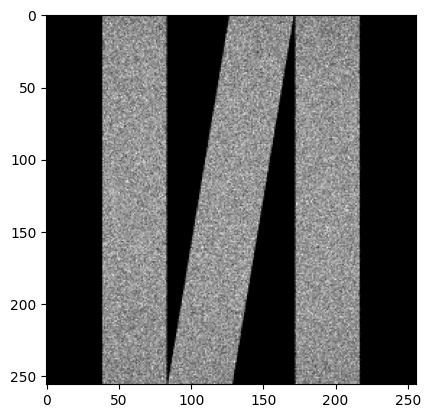

In [9]:
#@title Obteniendo una vista previa de la escena
mi.set_variant("scalar_rgb")

preview_scene = mi.load_dict(
{
  "type": "scene",
  "integrator": {"type": "path"},
  "sensor": {
    "type": "perspective",
    "fov": 60,
    "to_world": mi.ScalarTransform4f().look_at(
        [0, 0, 0],
        [0, 0, 1],
        [0, 1, 0]
    ),
    "film": {
        "type": "hdrfilm",
        "width": 256,
        "height": 256,
        "rfilter": {"type": "box"},
    },
    "sampler": {"type": "independent", "sample_count": 64}
  },

  "shape": {
    "type": "obj",
    "filename": "/content/objs/n.obj",
    "to_world":
      mi.ScalarTransform4f().translate(mi.ScalarPoint3f([0.0, 0.0, 1.0])),
    "bsdf": {"type": "diffuse", "reflectance": 1.0}
  },

  "emitter": {
    "type": "point",
    "position": [0, 0, 10],
    "intensity": 500.0
  },

  "relay_wall" :{
    "type": "rectangle",
    "to_world": mi.ScalarTransform4f().scale([1.0, 1.0, 1.0]).translate([0.0, 0.0, 0.0]),
    "bsdf": {"type": "diffuse", "reflectance": 1.0}
    }
}
)

if preview_scene is None:
  print("Error: La escena no se cargó correctamente")
else:
  image_preview = mi.render(preview_scene)
  image_preview = np.clip(image_preview, 0, 1)
  plt.imshow(image_preview)
  plt.show()

In [10]:
#@title Configurando la escena
mi.set_variant('llvm_ad_rgb')

import mitransient as mitr

geometry = mi.load_dict(
  {
    "type": "obj",
    "filename": "/content/objs/n.obj",
    "to_world": mi.ScalarTransform4f().translate(mi.ScalarPoint3f([0, 0, 1.0])),
    "bsdf": {"type": "diffuse", "reflectance": 1.0}
  }
)

emitter = mi.load_dict(
  {
    "type": "projector",
    "irradiance": 100.0,
    "fov": 0.2,
    "to_world": mi.ScalarTransform4f().translate(mi.ScalarPoint3f([-0.5, 0.0, 0.25]))
  }
)

transient_film = mi.load_dict(
  {
    "type": "transient_hdr_film",
    "width": 64,
    "height": 64,
    "temporal_bins": 300,
    "bin_width_opl": 0.006,
    "start_opl": 1.85,
    "rfilter": {"type": "box"}
  }
)

nlos_sensor = mi.load_dict(
  {
    "type": "nlos_capture_meter",
    "sampler": {"type": "independent", "sample_count": 25000},
    "account_first_and_last_bounces": False,
    "sensor_origin": [-0.5, 0.0, 0.25],
    "transient_film": transient_film
  }
)

relay_wall = mi.load_dict(
  {
    "type": "rectangle",
    "to_world": mi.ScalarTransform4f().scale([1.0, 1.0, 1.0]).translate([0.0, 0.0, 0.0]),
    "bsdf": {"type": "diffuse", "reflectance": 1.0},
    "nlos_sensor": nlos_sensor
  }
)

integrator = mi.load_dict(
  {
    "type": "transient_nlos_path",
    "nlos_laser_sampling": True,
    "nlos_hidden_geometry_sampling": True,
    "nlos_hidden_geometry_sampling_do_rroulette": False,
    "temporal_filter": "box"
  }
)

In [11]:
#@title Ensamblando toda la escena
scene = mi.load_dict({
  'type' : 'scene',
  'geometry' : geometry,
  'emitter' : emitter,
  'relay_wall' : relay_wall,
  'integrator' : integrator
})

In [12]:
#@title Renderizado
pixel = mi.Point2f(32, 32)
mitr.nlos.focus_emitter_at_relay_wall_pixel(pixel, relay_wall, emitter)
transient_integrator = scene.integrator()
data_steady, data_transient = transient_integrator.render(scene)
print(data_transient.shape)

(64, 64, 300, 3)


# <font color="#00BFFF"> <center> **Visualización de los datos adquiridos** </center> </font> <a name="tema5">
<img src="https://drive.google.com/uc?export=view&id=1nQFDrnkZM5BLc-UOJ3eHYnnUySz2xcV9" width="70%">

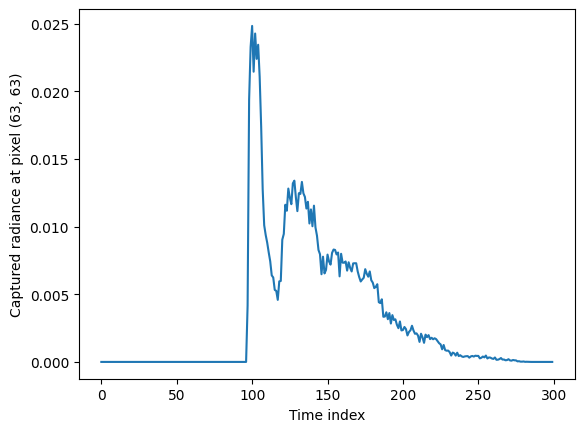

In [13]:
pixel_time_response(63, 63)

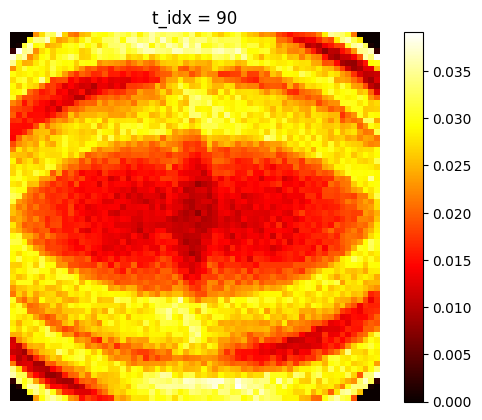

In [14]:
plot_time_instant(data_transient,90)

In [15]:
mitr.visualization.show_video(np.moveaxis(data_transient, 0, 1), 2)

<img src="https://drive.google.com/uc?export=view&id=1CF9s9KPZ6WZw2YWxxzNgQij-Y0FK2L1w" width="70%">

# <font color="#00BFFF"> <center> **Reconstrucción** </center> </font> <a name="tema6">

In [16]:
#@title Configuración
config_content = """MITSUBA_VERSION=3
MITSUBA2_TRANSIENT_NLOS_FOLDER=
MITSUBA3_TRANSIENT_NLOS_FOLDER=
LOG_LEVEL=INFO"""

with open('/root/.tal.conf', 'w') as f:
    f.write(config_content)

print("Contenido de .tal.conf:")
!cat /root/.tal.conf

Contenido de .tal.conf:
MITSUBA_VERSION=3
MITSUBA2_TRANSIENT_NLOS_FOLDER=
MITSUBA3_TRANSIENT_NLOS_FOLDER=
LOG_LEVEL=INFO

In [17]:
#@title Carga de las escenas
%%capture
load_from_drive('1vzeSkNGrzYvxV3NqZnMk5LEalQlk0p_7', 'yamls.zip')
!unzip "/content/yamls.zip" -d "/content"

In [19]:
#@title Renderizado con y-tal
!tal render /content/yamls/nlos-z.yaml

Found a render in progress (20250421-230155), continuing...
back_view for nlos-z steady render...
side_view for nlos-z steady render...
ground_truth for nlos-z...
Rendering nlos-z (single)...:   0% 0/1 [00:00<?, ?it/s]
Laser 1 of 1: 100%|##########| 100/100 [00:00<00:00, 1517.03it/s]
Rendering nlos-z (single)...: 100% 1/1 [00:30<00:00, 30.21s/it]
Reading partial results and generating HDF5 file...
Stored result in /content/yamls/20250421-230155/nlos-z.hdf5


In [22]:
#@title Lectura de la data_transient generada por y-tal
import tal
root = '/content/yamls/20250421-230155/nlos-z.hdf5'
data = tal.io.read_capture(os.path.join(root))

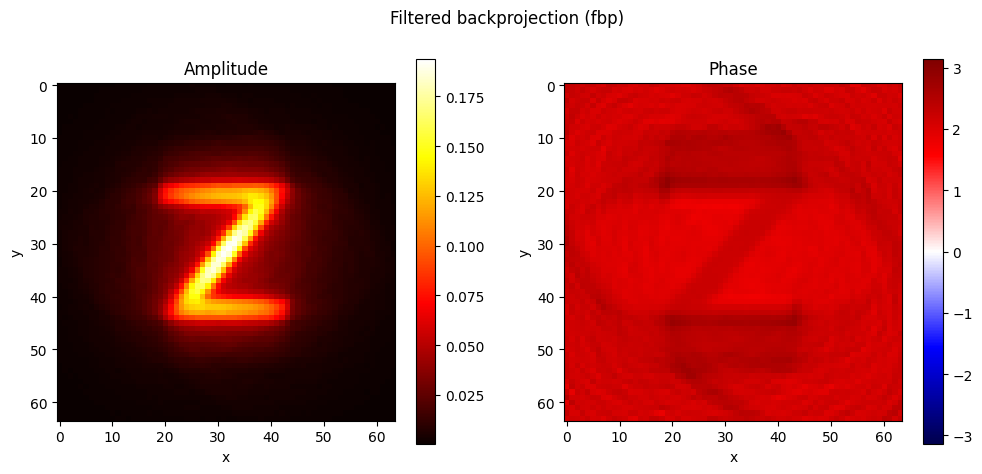

In [23]:
#@title Reconstrucción mediante FPB
volume_xyz = tal.reconstruct.get_volume_project_rw(data, depths=[1.0,])

H_1 = tal.reconstruct.fbp.solve(data,
                                wl_mean=0.07, wl_sigma=0.029,
                                volume_xyz=volume_xyz, camera_system=tal.enums.CameraSystem.DIRECT_LIGHT)
tal.plot.amplitude_phase(H_1, title='Filtered backprojection (fbp)')

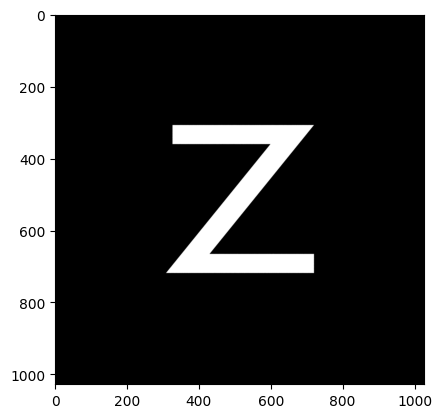

In [24]:
#@title Ground Truth
depth = data.scene_info['ground_truth']['depth'][..., 2]
plt.imshow(depth, cmap='gray')
plt.show()

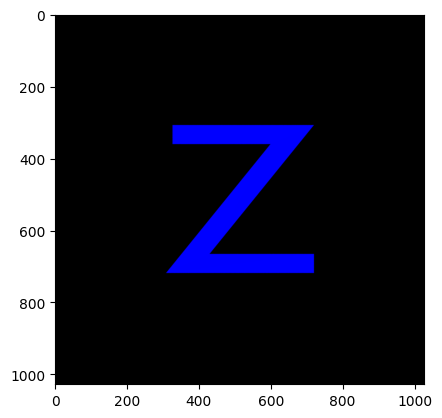

In [25]:
#@title Comprobación de las normales
normals = data.scene_info['ground_truth']['normals']
plt.imshow(np.clip(normals * -1, 0, 1))
plt.show()

# <font color="#00BFFF"> <center> **Referencias** </center> </font> <a name="referencias">

[1.Non-Line-of-Sight Imaging Edmund Optics](https://www.edmundoptics.com/knowledge-center/trending-in-optics/non-line-of-sight-imaging/)

[2.Mitsuba 3 documentation](https://mitsuba.readthedocs.io/en/stable/index.html#)

[3.Mitransient documentation](https://mitransient.readthedocs.io/en/latest/index.html#)

[4.(Your)-Transient Auxiliary Library repository](https://github.com/diegoroyo/tal/tree/master)

[5.Malla de triángulos 3D](https://es.wikipedia.org/wiki/Malla_de_tri%C3%A1ngulos_3D)

[6.3-D Coordinate Systems](https://learn.microsoft.com/en-us/previous-versions/windows/desktop/bb324490%28v=vs.85%29)

[7.Representation of the yaw pitch and roll angles](https://www.researchgate.net/figure/Representation-of-the-yaw-pitch-and-roll-angles_fig4_318959581)

[8.Multidimensional Arrays in C – 2D and 3D Arrays](https://www.geeksforgeeks.org/multidimensional-arrays-in-c/)

```javascript
@software{jakob2022mitsuba3,
    title = {Mitsuba 3 renderer},
    author = {Wenzel Jakob and Sebastien Speierer
    and Nicolas Roussel and Merlin Nimier-David
    and Delio Vicini and Tizian Zeltner
    and Baptiste Nicolet and Miguel Crespo
    and Vincent Leroy and Ziyi Zhang},
    note = {https://mitsuba-renderer.org},
    version = {3.0.1},
    year = 2022,
}
```

```javascript
@misc{mitransient,
      title        = {mitransient},
      author       = {Royo, Diego and Crespo, Miguel and Garcia-Pueyo, Jorge},
      year         = 2023,
      journal      = {GitHub repository},
      doi          = {https://doi.org/10.5281/zenodo.11032518},
      publisher    = {GitHub},
      howpublished = {\url{https://github.com/diegoroyo/mitransient}}
}
```

```javascript
@article{royo2022non,
	title        = {Non-line-of-sight transient rendering},
	author       = {Diego Royo and Jorge Garcia and Adolfo Munoz and Adrian Jarabo},
	year         = 2022,
	journal      = {Computers & Graphics},
	doi          = {https://doi.org/10.1016/j.cag.2022.07.003},
	issn         = {0097-8493},
	url          = {https://www.sciencedirect.com/science/article/pii/S0097849322001200}
}
```

```javascript
@software{Royo_y-tal,
author = {Royo, Diego and Luesia-Lahoz, Pablo},
license = {GPL-3.0},
title = {{y-tal}},
url = {https://github.com/diegoroyo/tal},
publisher = {GitHub},
doi = {https://doi.org/10.5281/zenodo.11197745},
}
```
